# <span style="color:darkred">Resubmission Updates Made </span>


<font color='darkred' size=3>
Group 5 -
Blake, Neddy, Rohit
    
    
> Please note, all updates from the initial submission have been marked in this red font with block quotes. Additionally the resubmission updates are summarized below.  
> - **Create Models** Added grid search, discussion of hyper parameter tuning, and more details to the results discussion. 
> - **Model Advantages** Added additional discussion of performance in terms of accuracy and training time. 
> - **Interpret Feature Importance** Added plots to to show negative and positive importance. Included discussion. 


</font>

 ![feedback.png](Minilab_Channe_Holmes_Nyatome.PNG)

# Data Preparation

In [1]:
import pandas as pd
import numpy as ny
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px
import os 
import sklearn.model_selection as ms
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model as lm
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score,brier_score_loss, precision_score, recall_score,f1_score)
import time

In [2]:
!pip3 install pickle5
import socket
import pickle5 as pickle

is_rohit=socket.gethostname()=='Rohits-MacBook-Pro.local'
is_blake=socket.gethostname()=='BJH-ML-machine'
is_neddy=(is_rohit+is_blake==0)

if(is_rohit):
    with open('~/Documents/yelp_datasets/df_business_eda.pickle', "rb") as f:
      pick_data = pickle.load(f)
      pick_data.to_pickle('~/Documents/yelp_datasets/df_business_eda_proto4.pickle')
    df_business_eda = pd.read_pickle("~/Documents/yelp_datasets/df_business_eda_proto4.pickle")
    
if(is_blake):
    df_business_eda = pd.read_pickle("df_business_eda.pickle")

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
df_business_eda.head(2)

,rating_category,stars,Beauty & Spas,BusinessAcceptsCreditCards,Restaurants,is_open,parking_lot,city_state,zip3,RestaurantsPriceRange2,text,checkin_count,useful_count,cool_count,funny_count,review_count,review_word_count
1,2,5.0,False,False,False,True,False,Scottsdale_AZ,852,NaN,NaN,9.0,4,1,2,4,121.000000
3,0,2.5,False,True,False,False,True,North Las Vegas_NV,890,4.0,NaN,3.0,1,0,0,3,26.666667


In [4]:
categorical_cols=df_business_eda.select_dtypes(include=['object']).columns

df_business_hot=df_business_eda

for col in categorical_cols:
    dummies=pd.get_dummies(df_business_hot[col], dummy_na=True, prefix=col)
    df_business_hot=df_business_hot.\
        drop(col,axis=1).\
    merge(
        dummies,
        how='left',
        left_index=True,
        right_index=True
        )
    
df_business_hot=df_business_hot.fillna(False)
df_business_hot.head(2)

,rating_category,stars,Beauty & Spas,BusinessAcceptsCreditCards,Restaurants,is_open,parking_lot,RestaurantsPriceRange2,text,checkin_count,...,zip3_928,zip3_930,zip3_940,zip3_952,zip3_953,zip3_959,zip3_967,zip3_981,zip3_nan,zip3_nan
1,2,5.0,False,False,False,True,False,False,False,9,...,0,0,0,0,0,0,0,0,0,0
3,0,2.5,False,True,False,False,True,4,False,3,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_business_hot["above_average"] = ny.where(df_business_hot["stars"] > 3.5, 0, 1)
y=df_business_hot.rating_category
y2 = df_business_hot["above_average"]
X=df_business_hot.drop(["rating_category", "stars","above_average"], axis=1)
#Scale your data
scaler = StandardScaler()
scaler.fit(X) 
X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
X_scaled.head(2)

,Beauty & Spas,BusinessAcceptsCreditCards,Restaurants,is_open,parking_lot,RestaurantsPriceRange2,text,checkin_count,useful_count,cool_count,...,zip3_928,zip3_930,zip3_940,zip3_952,zip3_953,zip3_959,zip3_967,zip3_981,zip3_nan,zip3_nan
0,-0.284181,-1.686292,-0.507601,0.489254,-0.580683,-0.800061,-0.255661,-0.150669,-0.273438,-0.252466,...,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.043309,0.0
1,-0.284181,0.593017,-0.507601,-2.043927,1.722109,3.225868,-0.255661,-0.156851,-0.314588,-0.273815,...,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.043309,0.0


In [6]:
num_cv_iterations = 5
num_instances = len(y)
cv_object = ms.ShuffleSplit(n_splits=num_cv_iterations,
                         random_state=123,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=5, random_state=123, test_size=0.2, train_size=None)


In [7]:
def cv_train(name,model,x,y):
    print(f"====Performing Cross Validation for {name}")
    print(f" Iteration ", end = '')
    iter_num=0
    res=pd.DataFrame()

    for train_indices, test_indices in cv_object.split(x,y):
        t = time.time()
        print(f" {iter_num},", end = '')

        X_train = x.iloc[train_indices]
        y_train = y.iloc[train_indices]

        X_test = x.iloc[test_indices]
        y_test = y.iloc[test_indices]

        model.fit(X_train,y_train)  # train object
        y_hat = model.predict(X_test) # get test set precitions

        conf = mt.confusion_matrix(y_test,y_hat)
        
        row=pd.DataFrame([iter_num],columns=['Iteration'])
        row["accuracy"]=accuracy_score(y_test, y_hat)
        row["precision"]=precision_score(y_test, y_hat, average="macro")
        row["recall"]=recall_score(y_test, y_hat, average="macro")
        row["f1"]=f1_score(y_test, y_hat, average="macro")
        row["average_seconds"]= ny.round(time.time() - t)

        res=res.append(row)
        iter_num+=1
    
    #Summarize CV Results 
    summary=res.drop("Iteration",axis=1).agg("mean").to_frame().T
    summary.insert(0,"model",model)
    summary.insert(0,"name",name)
    print("  Cross-validation complete")

    return(summary)

# Create Models	50	

Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. 
Assess how well each model performs (use 80/20 training/testing split for your data). 
Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

<font color="darkred" size="3">
                             
> Added grid search, discussion of hyper parameter tuning, and more details to the results discussion. 

</font> 

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
grid={'C': [0.001,0.01,0.1,1,10,100,1000], "penalty":["l1","l2","elasticnet","none"]}# l1 lasso l2 ridge

for type in ['newton-cg', 'lbfgs','liblinear','sag']: # removed 'saga' crashing during gridsearch
    logreg=LogisticRegression(solver=type)
    logreg_cv=GridSearchCV(logreg,grid,cv=4, n_jobs=-1)
    logreg_cv.fit(X_scaled,y2)
    print(type)
    print(logreg_cv.best_params_)
    print("-----")

newton-cg
{'C': 0.001, 'penalty': 'none'}
-----
lbfgs
{'C': 1000, 'penalty': 'l2'}
-----
liblinear
{'C': 1000, 'penalty': 'l2'}
-----
sag
{'C': 0.001, 'penalty': 'none'}
-----


<font color="darkred" size="3">
                             
> To find the optimal hyperparameters for each of the logistic regression models we used a grid search method. For the grid search we tested different values of C and penalties. 
    
> - **C** *Inverse of regularization strength* - Values of 0.001,0.01,0.1,1,10,100, and 10000 were used in the grid search. Regularization is a technique used to prevent overfitting. Regularization penalizes high coefficient values. C as the inverse regularization strength implies the lower the C value the lower the resulting model coefficients will be. The grid search chose a C of 1000 for *Lbfgs* and *liblinear* and 0.001 for *newton-cg* and *sag*. 
    
> - **Penalty** The penalty types of *l1*, *l2*, *elasticnet*, and *none* were used in the grid search. The penalty term is added to the loss function to introduce bias and prevent overfitting. The grid search chose *l2* for *lbfgs* and *liblinear*. The grid search chose to include no penalty for *newton-cg* and *sag*. It should be noted that most models do not support all penalty types. For example *newton-cg*, *sag*, and *lbfgs* do not support *l2* penalty type. 

</font> 

In [13]:
from sklearn.linear_model import SGDClassifier

grid2 = {
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1","elasticnet", "none"],
}
for loss_type in ["hinge", "log", "squared_hinge", "modified_huber"]:
    model = SGDClassifier(loss=loss_type, max_iter=1000)
    SGD = GridSearchCV(model, param_grid=grid2, cv=4, n_jobs=-1)
    SGD.fit(X_scaled,y2)
    print(loss_type)
    print(SGD.best_params_)
    print("-----")

hinge
{'alpha': 0.001, 'penalty': 'none'}
-----
log
{'alpha': 0.001, 'penalty': 'none'}
-----
squared_hinge
{'alpha': 0.01, 'penalty': 'l1'}
-----
modified_huber
{'alpha': 0.01, 'penalty': 'none'}
-----


<font color="darkred" size="3">
                             
> To find the optimal hyperparameters for each of the SGDClassifier models we used a grid search method. For the grid search we tested different values of 𝜶 and penalty.
    
> - **alpha(𝜶)** - * 𝜶 is a constant that multiplies the regularization term, and is involved in the learning rate*. Values of 0.0001, 0.001, 0.01, and 0.1 were used in the grid search. The grid search chose 0.001 for *hinge* and *log*, and chose 0.01 for *squared_hinge* and *modified_huber*. 
    
> - **penalty** - The penalty types of *l1*, *l2*, *elasticnet*, and *none* were used in the grid search. Gridsearch chose *l1* for *squared_hinge*. While not including a penalty term was chosen for the remaining three loss functions of *hinge*, *log*, and *modified_huber*. 

</font>

In [15]:
#LogisticRegression
log_newton_model = LogisticRegression(n_jobs=-1, penalty='none', C=0.001, class_weight=None, solver='newton-cg' )
log_lbfgs_model = LogisticRegression(n_jobs=-1, penalty='l2', C=1000, class_weight=None, solver='lbfgs' )
log_liblinear_model = LogisticRegression(n_jobs=-1, penalty='l2', C=1000, class_weight=None, solver='liblinear' )
log_sag_model = LogisticRegression(n_jobs=-1,penalty='none', C=0.001, class_weight=None, solver='sag' )
log_saga_model = LogisticRegression(n_jobs=-1,penalty='l2', C=1.0, class_weight=None, solver='saga')
#SGDClassifier
svm_sgd_model = lm.SGDClassifier(n_jobs=-1,alpha=0.001,penalty="none", loss="hinge")
log_sgd_model = lm.SGDClassifier(n_jobs=-1,alpha=0.001,penalty="none", loss="log")
squared_hinge_sgd_model = lm.SGDClassifier(n_jobs=-1,alpha=0.01,penalty="l1", loss="squared_hinge")
modified_huber_sgd_model = lm.SGDClassifier(n_jobs=-1,alpha=0.01,penalty="none", loss="modified_huber")

# Compare Competing Models

# Model Advantages	10

Discuss the advantages of each model for each classification task.Does one type of model offer superior performance over another in terms of prediction accuracy? 

In [17]:
#supressing warnings, many of the logistic models complain during fitting
import warnings
warnings.filterwarnings('ignore')

#Run CV on all models and combine results into dataframe
cv_results=cv_train("log_newton",log_newton_model, X_scaled, y2).\
    append(cv_train("log_lbfgs",log_lbfgs_model, X_scaled, y2)).\
    append(cv_train("log_liblinear",log_liblinear_model, X_scaled, y2)).\
    append(cv_train("log_sag",log_sag_model, X_scaled, y2)).\
    append(cv_train("log_saga",log_saga_model, X_scaled, y2)).\
    append(cv_train("log_sgd",log_sgd_model, X_scaled, y2)).\
    append(cv_train("svm_sgd",svm_sgd_model, X_scaled, y2)).\
    append(cv_train("squared_hinge_sgd",squared_hinge_sgd_model, X_scaled, y2)).\
    append(cv_train("modified_huber_sgd",modified_huber_sgd_model, X_scaled, y2)).\
    sort_values("f1", ascending=False)

====Performing Cross Validation for log_newton
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete
====Performing Cross Validation for log_lbfgs
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete
====Performing Cross Validation for log_liblinear
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete
====Performing Cross Validation for log_sag
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete
====Performing Cross Validation for log_saga
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete
====Performing Cross Validation for log_sgd
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete
====Performing Cross Validation for svm_sgd
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete
====Performing Cross Validation for squared_hinge_sgd
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete
====Performing Cross Validation for modified_huber_sgd
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete


,name,model,accuracy,precision,recall,f1,average_seconds
0,modified_huber_sgd,"SGDClassifier(alpha=0.01, loss='modified_huber...",0.691411,0.692782,0.690117,0.689809,23.8
0,log_sgd,"SGDClassifier(alpha=0.001, loss='log', n_jobs=...",0.690760,0.691648,0.689652,0.689477,6.4
0,log_lbfgs,"LogisticRegression(C=1000, n_jobs=-1)",0.689779,0.690711,0.688632,0.688444,12.6
0,log_newton,"LogisticRegression(C=0.001, n_jobs=-1, penalty...",0.689769,0.690704,0.688621,0.688432,24.4
0,log_liblinear,"LogisticRegression(C=1000, n_jobs=-1, solver='...",0.689769,0.690704,0.688621,0.688432,21.0
0,svm_sgd,"SGDClassifier(alpha=0.001, n_jobs=-1, penalty=...",0.688417,0.691810,0.686569,0.685562,7.4
0,squared_hinge_sgd,"SGDClassifier(alpha=0.01, loss='squared_hinge'...",0.678947,0.679968,0.677717,0.677401,77.2
0,log_sag,"LogisticRegression(C=0.001, n_jobs=-1, penalty...",0.672530,0.673438,0.671311,0.670987,13.0
0,log_saga,"LogisticRegression(n_jobs=-1, solver='saga')",0.665562,0.666403,0.664330,0.663966,15.0


In [22]:
cv_results

,name,model,accuracy,precision,recall,f1,average_seconds
0,modified_huber_sgd,"SGDClassifier(alpha=0.01, loss='modified_huber...",0.691411,0.692782,0.690117,0.689809,23.8
0,log_sgd,"SGDClassifier(alpha=0.001, loss='log', n_jobs=...",0.690760,0.691648,0.689652,0.689477,6.4
0,log_lbfgs,"LogisticRegression(C=1000, n_jobs=-1)",0.689779,0.690711,0.688632,0.688444,12.6
0,log_newton,"LogisticRegression(C=0.001, n_jobs=-1, penalty...",0.689769,0.690704,0.688621,0.688432,24.4
0,log_liblinear,"LogisticRegression(C=1000, n_jobs=-1, solver='...",0.689769,0.690704,0.688621,0.688432,21.0
0,svm_sgd,"SGDClassifier(alpha=0.001, n_jobs=-1, penalty=...",0.688417,0.691810,0.686569,0.685562,7.4
0,squared_hinge_sgd,"SGDClassifier(alpha=0.01, loss='squared_hinge'...",0.678947,0.679968,0.677717,0.677401,77.2
0,log_sag,"LogisticRegression(C=0.001, n_jobs=-1, penalty...",0.672530,0.673438,0.671311,0.670987,13.0
0,log_saga,"LogisticRegression(n_jobs=-1, solver='saga')",0.665562,0.666403,0.664330,0.663966,15.0


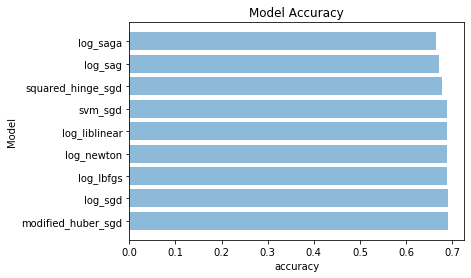

In [49]:
cv_sort=cv_results.sort_values("accuracy", ascending=False)

plt.barh(cv_sort.name, cv_sort.accuracy, align='center', alpha=0.5)
plt.xlabel('accuracy')
plt.ylabel('Model')
plt.title('Model Accuracy')

plt.show()

<font color="darkred" size="3">

> After using grid search to optimize the hyper parameters used in the various models, we compared the optimized models to eachother. In total we compared four Stoichastic Gradient Descent(SGD) models and 5 Logistic Regression models from sci-kit. There was not great variance in the performance of the nine models. The lowest ranking model was the logistic regression using the saga solver with an accuracy of 0.665 and the highest ranking model was the SGD modified huber with an accuracy of 0.691. The second ranking model was the SGD logistic regression model. Typically a sepearte investigation of precision, recall, and f1 score would be necessary but each of the scores was relatively consistent across the performance metrics. This is likely because it is a perfectly balanced classification problem. 
</font>

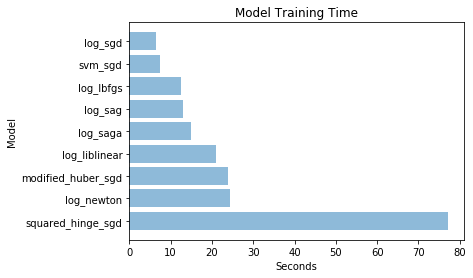

In [35]:
cv_sort=cv_results.sort_values("average_seconds", ascending=False)

plt.barh(cv_sort.name, cv_sort.average_seconds, align='center', alpha=0.5)
plt.xlabel('Seconds')
plt.ylabel('Model')
plt.title('Model Training Time')

plt.show()

In [47]:
np.median(cv_results.average_seconds)

15.0

<font color="darkred" size="3">

> While accuracy, precision, and recall are critical to evaluating the performance of a model, it is also important to understand the time necessary to train the model. As data sets get larger it becomes increasingly important to factor in training time. The top model in terms of accuracy, SGD *modified_huber*, took 23.8 seconds to train which was greater than the median value of 15 seconds. The SGD logarithmic regression was the fastest performer at 6.4 seconds. The SGD *squared_hinge* took the longest at 77 seconds. 

</font>        


In our quest to find the best parameters that will give us the least error (minimize the cost function) in predicting the output, we fitted each solver in Scikit-learn in the logistic regression.In addition, we also used SGD classifier so it can implement the stochastic gradient descent learning routine that will support different loss functions and penalties for our classification.  For SVM, we did use the SGD classifier to train the model in a reasonable timeframe.  Both the Logistic regression and SVM with a linear kernel yielded very similar performance in terms of prediction accuracy. Even after tuning the parameters to find the optimum value for each parameter so that our model's accuracy can improve, they both had similar performance.  

In terms of training time or efficiency? The default Scikit-learn solver lbfgs had the least training time compared to other logistic regression models fitted for other resolvers. This is to be expected as the lbfgs algorithm uses the least memory by employing a method where iterations start at a random optimal value(x) and proceeds to refine that optimal value with a series of better estimates x1, x2. The logisticRegression fitted for SGDClassifier did did not have faster training time compared to the LR model fitted for lbfgs. Comparing the LogisticRegression with default solver with the SVM model, the LogisticRegression still performed efficiently in terms of training time.  

<font color="darkred" size="3">
                             
> The top performing Logistic Regression Model was the LBFGS. While the LBFGS accuracy, precision, and recall were not quite as high as the SGD modified huber, it did train in half the time as the modified huber. If the requirement existed to handle a much greater amount of data or to have quicker model training times we could consider using the logistic Regression LBFGS. 
    
> The top performing SVM model was the Stoichastic Gradient Descent modified huber. The modified huber is a quadratically smoothed SVM model. The training time was above average, but not so significant that we will consider using other models. 
    

</font> 

In [48]:

#WINNER-Train final logistic regression model on all scaled data
log_lbfgs_model_final = LogisticRegression(n_jobs=-1, penalty='l2', C=1000, class_weight=None, solver='lbfgs' )
log_lbfgs_model_final.fit(X_scaled,y2)

#Train final SVM model on all scaled data

svm_sgd_model_final = modified_huber_sgd_model = lm.SGDClassifier(n_jobs=-1,alpha=0.01,penalty="none", loss="modified_huber")
svm_sgd_model_final.fit(X_scaled,y2)

SGDClassifier(alpha=0.01, loss='modified_huber', n_jobs=-1, penalty='none')

# Interpret Feature Importance	30

Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

The objective is to predict that in a given business category, the number of stars the customer provides as part of feedback is determined by multiple factors such as the business location and whether or not the business does provide parking. One of our response variables is customer category rating (in high, low, medium to indicate customers rating of the business). We expect our model to tell the customer the type of rating (high, low, medium) they should expect if there business has certain factors.  

Our analysis shows that the most important feature in our dataset is the cool_count feature. Given that the importance is determined by the qualitative comparison between pairs of predictors of the variables, we think some variables are more important than others because they contribute more to the prediction of the response variable in all possible combinations of predictors. Looking at the coefficients closely, the value for cool_count is negative. In general,  this simply implies that the probability that the event identified by the dependent variable happenning decreases as the value of the independent variable increases. In our context/dataset, this means that the likelihood of the count_cool or the number of potential customers who thought that the review was cool is less likely to cause the change on the business being rated as low, medium or high & the star rating.Funny_count is our next important feature, it's coefficient is positive. This indicates that a one unit increase in this feature will affect the outcome of the customer experience & star rating by a factor of 4.39. We also have to take into consideration that precision (how accurate our model is in making a prediction) is only 69% while accuracy is 68%. These insights tell us that we need to tune our parameters to increase our accuracy as we continue to work with this dataset. We think we need more insigth before deciding which features to remove from the dataset. 
  

In [111]:
def get_coefficients(model):
    feature_coef = model.coef_[0]
    sorted_idx = np.argsort(feature_coef)
    res=dict(zip(np.array(X.columns)[sorted_idx],feature_coef[sorted_idx]))
    res=dict(sorted(res.items(), key=lambda item: item[1], reverse=True))
    res=pd.DataFrame({"variables":res.keys(), "values":res.values()})
    return(res)

def get_importance(model):
    feature_importance = abs(model.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    res=dict(zip(np.array(X.columns)[sorted_idx],feature_importance[sorted_idx]))
    res=dict(sorted(res.items(), key=lambda item: item[1], reverse=True))
    return(res)

def plot_importance(importance_dict, top_n=20):
    importance_dict=dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))
    
    names=list(importance_dict.keys())[0:top_n]
    values=list(importance_dict.values())[0:top_n]
    
    pos = np.arange(len(names)) + .5
    featfig = plt.figure(figsize=(10, top_n/2))
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, values, align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(names, fontsize=12)
    featax.set_xlabel('Relative Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
def plot_coeffs(title,mod, top_n=20):
    res=get_coefficients(mod)[get_coefficients(mod).variables.isin(list(get_importance(mod).keys())[0:top_n])]   
    
    names=res.variables
    values=res["values"]
    plt.barh(names, values, align='center', alpha=0.5)
    plt.xlabel('Coefficients')
    plt.ylabel('')
    plt.title(title)
    plt.show()

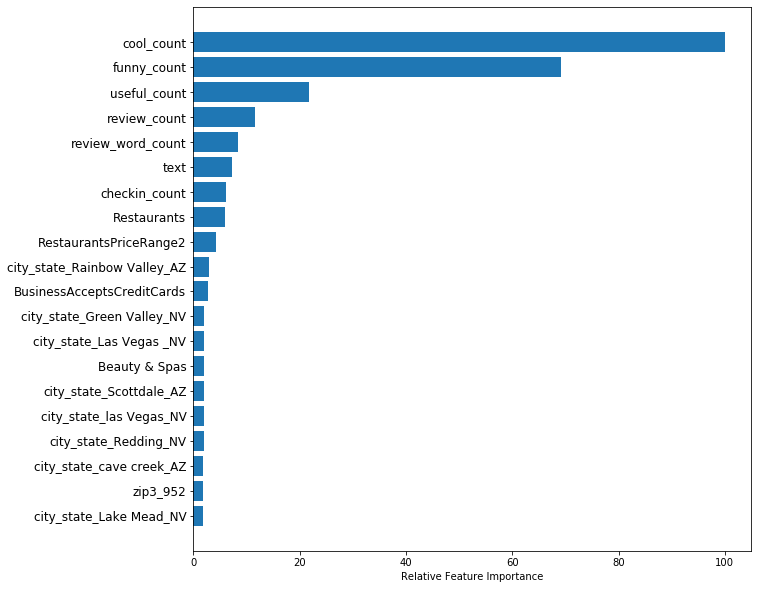

In [51]:
logistic_importance=get_importance(log_lbfgs_model_final)
plot_importance(logistic_importance,top_n=20)

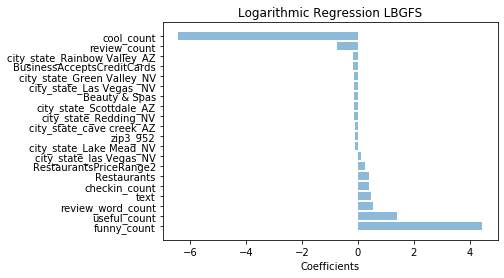

In [110]:
plot_coeffs("Logarithmic Regression LBGFS",log_lbfgs_model_final)

<font color="darkred" size="3">
                             
> The top 20 features for LBGFS include a wide variety of features, including geographic, relating to user engagement (e.g. useful_count, checkin_count), restaurants, restaurant price, accepts credit cards, and Beauty & Spas. However those with the greatest importance are all related to user engagement. The number of cool and review counts were negative. Suggesting the more cool counts and reviews the more likely the business will be rated below average. While useful_count and funny_count have strong positive coefficients suggesting businesses with higher values to be more likely to be rated above average. 

</font>

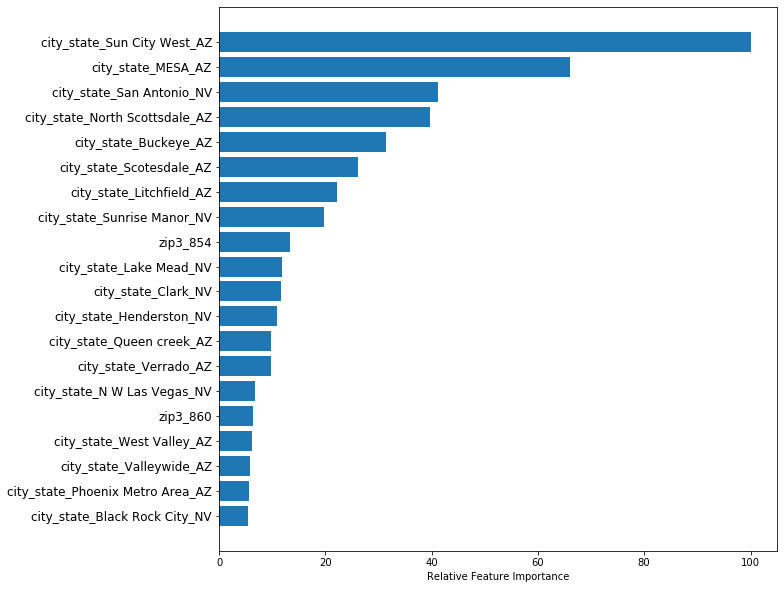

In [53]:
svm_importance=get_importance(svm_sgd_model_final)
plot_importance(svm_importance,top_n=20)

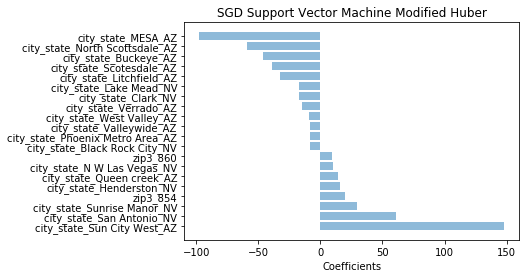

In [109]:
plot_coeffs("SGD Support Vector Machine Modified Huber",svm_sgd_model_final)

<font color="darkred" size="3">
                             
> The top 20 features in terms of importance are all relating to location. The chart above shows variables with extreme positive and negative values. The positive coefficient values suggest that a business in that location would be more likely to be rated above average, while a negative coefficient value means that location would be more likely to be below average.

</font>

# Interpret Support Vectors	10

Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.

We subsampled our data to train the SVC model and our analysis shows that cool_count is the most important feature in our model. Given that SVC penalizes the algorithm each time there's a misclassfication, this output tells us that cool_count has the highest size of co-efficient when compared to other predictors and we should get rid of the less important features with less variance from the model. In addition, the precision for SVC is only 69% while accuracy is only 68% and maybe removing the less importang variables may increase these values. 

In [ ]:
df_business_subset = df_business_hot.sample(frac=0.2,replace=True)

ys=df_business_subset.rating_category
ys2 = df_business_subset["above_average"]
Xs=df_business_subset.drop(["rating_category", "stars","above_average"], axis=1)
#Scale your data

scaler.fit(Xs) 
Xs_scaled = pd.DataFrame(scaler.transform(Xs),columns = Xs.columns)
Xs_scaled.head(2)

In [ ]:
from sklearn.svm import SVC

In [ ]:
for train_indices, test_indices in cv_object.split(Xs_scaled,ys2):

        X_train = Xs_scaled.iloc[train_indices]
        y_train = ys2.iloc[train_indices]

        X_test = Xs_scaled.iloc[test_indices]
        y_test = ys2.iloc[test_indices]

In [ ]:
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='scale') # get object
svm_clf.fit(X_train, y_train)  # train object

y_hat = svm_clf.predict(X_test) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)


In [ ]:
precision=precision_score(y_test, y_hat)
recall=recall_score(y_test, y_hat)
f1=f1_score(y_test, y_hat)
print(f'accuracy:{acc}, precision:{precision}, recall:{recall}, f1:{f1}')
print(conf)

In [ ]:
svc_importance=get_importance(svm_clf)
plot_importance(svc_importance,top_n=20)